# Supervised Learning
***Eric Gu <br>
September 25, 2018***

- - -

This notebook will explore several fundamental techniques in supervised learning by applying 5 learning algorithms on two interesting classification problems. Namely, the 5 algorithms are:
* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* *k*-Nearest Neighbors

For the purposes of the exercise, we will skip using dimensionality reduction algorithms (feature selection or feature extraction). Instead, we focus on describing the classification problems, training and testing them, and analyzing the results. 

*Written in Jupyter Notebook using Python's scikit-learn library and [documentation](http://scikit-learn.org/stable/user_guide.html), and with additional reference to [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) and [Ritchie Ng's website](https://www.ritchieng.com). Data sourced from [Kaggle.com](https://www.kaggle.com/datasets).* 

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import datasets

## Avocado Prices
Let's first explore Hass avocado prices from 2015–2018, downloaded from the Hass Avocado Board website in May 2018 and [compiled on Kaggle.com](https://www.kaggle.com/neuromusic/avocado-prices). We'll try to predict the average price of avocados depending on sales numbers, date & time, and location.

In [46]:
avocado_data = pd.read_csv("./Datasets/avocado-prices.csv", sep=',', header='infer', index_col=0)
avocado_data.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,month,day,year,region
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,12,27,2015,Albany
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,12,20,2015,Albany
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,12,13,2015,Albany
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,12,6,2015,Albany
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,11,29,2015,Albany


The dataset contains 18249 rows of weekly retail scan data for national retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. The table reflects an expanded, multi-outlet retail data set, which includes an aggregation of grocery, mass, club, drug, dollar, and military channels. 

The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU's) correspond to the following:

* Small/Medium Hass Avocado (~3-5oz avocado) | #4046
* Large Hass Avocado (~8-10oz avocado) | #4225
* Extra Large Hass Avocado (~10-15oz avocado) | #4770

This dataset is relatively simple: it has very few features, some of which are likely correlated. However, because it comes from real-world data, it is likely messy and will provide an interesting comparison between different learning algorithms' ability to identify the dataset's underlying structure through the noise. Additionally, because we will encode the categorical variables and discretize the average prices to turn it into a multiclass classification problem, the dimensionality of the problem will greatly increase. Finally, and perhaps most importantly, this dataset contains only a posteriori information on average prices of avocado sales in relation to the times and locations they were sold at. Without feature engineering additional data like weather, transportation costs (e.g. oil prices), and cost of living, we can only hope for our models to indirectly discover those potentially underlying causal relationships that correlate with time and location. 

### Preprocessing
The data is missing no values, and is well-balanced across type, region, and datetime. I've broken the original 'Date' feature into 'month', 'day,' and 'year' columns in the CSV before importing. For the sake of brevity, we will skip rudimentary data visualization and inspection in this notebook. 

Before doing anything, let's first split our data into training and testing sets. Just to be safe, we will do everything we do to the training set to the testing set, in parallel.

In [47]:
avocado_train, avocado_test = train_test_split(avocado_data, test_size=0.2)

#### Feature Engineering and Standardization
However, we do need to change our raw feature vectors into a representation more suitable for our downstream estimators. This includes encoding categorical features into numerical values and standardizing the data.

Let's first standardize the numerical features—this will help all features contribute equally in *k*-Nearest Neighbors and prevent gradient saturation when fitting the neural networks. 

In [48]:
# Cols "Total Volume" to "XLarge Bags"
unscaled_cols = avocado_train.columns[1:9]

avocado_train_scaled = avocado_train.copy()
avocado_test_scaled = avocado_test.copy()

scaler = StandardScaler()
avocado_train_scaled[unscaled_cols] = scaler.fit_transform(avocado_train_scaled[unscaled_cols])
avocado_test_scaled[unscaled_cols] = scaler.fit_transform(avocado_test_scaled[unscaled_cols])

Now, let's *one-hot encode* our categorical features (region, type, year) into multiple new binary features. This avoids the primary pitfall that comes with Label encoding, which induces order that simply does not exist in the data (e.g. Albany < Seattle, or Boston = the average of Boise and BuffaloRochester). For some estimators like decision trees, this distinction does not matter, but neural networks and SVMs can be sensitive to ordered categorical values. 

In [49]:
# Use Pandas get_dummies() to one-hot encode categorical variables
avocado_train_encoded = pd.get_dummies(avocado_train_scaled, columns=["region", "type", "year"], prefix=["region", "type", "year"])
avocado_test_encoded = pd.get_dummies(avocado_test_scaled, columns=["region", "type", "year"], prefix=["region", "type", "year"])

However, month and day are cyclical features that would do well to be represented on a circle to preserve information, such as month 12 and month 1 being close to each other and not that far. (For an in depth treatment, see [this blog.](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html)) Hopefully, this additional information may allow the algorithms to glean some insight on avocado prices' correlation to the time of year, or even month. 

In [50]:
# Normalize day and month to sin and cos, assuming months are uniformly 30 days long
avocado_train_encoded['day_sin'] = np.sin(avocado_train_encoded.day*(2.*np.pi/30))
avocado_train_encoded['day_cos'] = np.cos(avocado_train_encoded.day*(2.*np.pi/30))
avocado_train_encoded['month_sin'] = np.sin((avocado_train_encoded.month-1)*(2.*np.pi/12))
avocado_train_encoded['month_cos'] = np.cos((avocado_train_encoded.month-1)*(2.*np.pi/12))
del avocado_train_encoded['month']
del avocado_train_encoded['day']

avocado_test_encoded['day_sin'] = np.sin(avocado_test_encoded.day*(2.*np.pi/30))
avocado_test_encoded['day_cos'] = np.cos(avocado_test_encoded.day*(2.*np.pi/30))
avocado_test_encoded['month_sin'] = np.sin((avocado_test_encoded.month-1)*(2.*np.pi/12))
avocado_test_encoded['month_cos'] = np.cos((avocado_test_encoded.month-1)*(2.*np.pi/12))
del avocado_test_encoded['month']
del avocado_test_encoded['day']

To convert this to a classification problem, we should discretize our output (average price of avocados) into quantile-based price ranges (from "Very Cheap" to "Very Pricey"). 

In [51]:
# Identify bin cutoffs that that divide AveragePrice into 5 quantiles
train_ser, train_bins = pd.qcut(avocado_train_encoded["AveragePrice"], 5, retbins=True, labels=False)
test_ser, test_bins = pd.qcut(avocado_test_encoded["AveragePrice"], 5, retbins=True, labels=False)

# Replace AveragePrice with LabeledPrice, a categorical variable
avocado_price_range_labels = ["Very Cheap", "Cheap", "Average", "Pricey", "Very Pricey"]
trainLabeledPrice = pd.cut(avocado_train_encoded["AveragePrice"], bins=train_bins, labels=avocado_price_range_labels, include_lowest=True)
testLabeledPrice = pd.cut(avocado_test_encoded["AveragePrice"], bins=test_bins, labels=avocado_price_range_labels, include_lowest=True)


avocado_train_processed = avocado_train_encoded.copy()
avocado_test_processed = avocado_test_encoded.copy()

avocado_train_processed.insert(loc=0, column="Price", value=trainLabeledPrice)
avocado_test_processed.insert(loc=0, column="Price", value=testLabeledPrice)
del avocado_train_processed['AveragePrice']
del avocado_test_processed['AveragePrice']

avocado_Y_train = avocado_train_processed.iloc[:, :1]
avocado_X_train = avocado_train_processed.iloc[:, 1:]
avocado_Y_test = avocado_test_processed.iloc[:, :1]
avocado_X_test = avocado_test_processed.iloc[:, 1:]

### Training

Because this dataset has an equal number of observations for each class by construction, and we want to weigh all predictions and prediction errors equally, *we will use **accuracy** as our classification scoring metric*. Below are several helper methods that will help us automatically plot validation curves and learning curves while incorporating stratified K-fold cross validation (CV). We default to 5 folds to strike a balance between the size of the dataset and the computational complexity of fitting algorithms like neural networks many times. 

All algorithm implementations are through the scikit-learn library. 

In [52]:
# Calculate accuracy on training and validation set using range of parameter values
def calculateValidationCurve(estimator, X, Y, 
                             param_name, param_range,
                             title, xlabel, ylabel,
                             cv=5, scoring="accuracy",
                             lw=2, n_jobs=1):
    
    train_scores, validation_scores = validation_curve(estimator, 
                                                 X, 
                                                 Y, 
                                                 param_name, 
                                                 param_range,
                                                 cv=cv, 
                                                 scoring=scoring, 
                                                 n_jobs=n_jobs)
    
    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for validation set scores
    validation_mean = np.mean(validation_scores, axis=1)
    validation_std = np.std(validation_scores, axis=1)

    # Plot mean accuracy scores for training and validation sets
    plt.plot(param_range, train_mean, label="Training score", color="darkorange", lw=lw)
    plt.plot(param_range, validation_mean, label="Cross-validation score", color="navy", lw=lw)

    # Plot accurancy bands for training and validation sets
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange", lw=lw)
    plt.fill_between(param_range, validation_mean - validation_std, validation_mean + validation_std, alpha=0.2, color="navy", lw=lw)

    # Create plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.grid()
    plt.legend(loc="best")
    return plt
    
def plotLearningCurve(estimator, X, Y,
                      title, xlabel, ylabel,
                      ylim=None, cv=5, scoring="accuracy",
                      n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, Y, 
        cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Plot mean and standard deviation for training and cross-validation learning curves
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#### Decision Trees with Pre-Pruning
We use the default implementation for DecisionTreeClassifier, which uses Gini impurity to measure the quality of a split. Plotting the max depth of the decision trees against the accuracy score gives us the following graph:

<module 'matplotlib.pyplot' from 'C:\\Users\\Eric\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

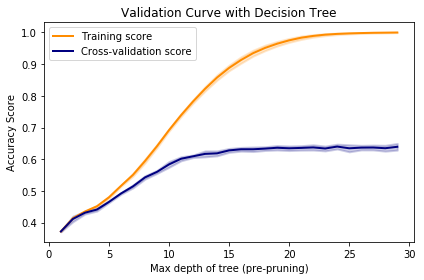

In [12]:
calculateValidationCurve(DecisionTreeClassifier(), avocado_X_train, avocado_Y_train,
                         "max_depth", range(1,30),
                         "Validation Curve with Decision Tree", "Max depth of tree (pre-pruning)", "Accuracy Score", 
                         scoring="accuracy", n_jobs=4)

It looks like the cross-validation score plateaus at around max depth = 15, at most 18. As the decision trees grow larger, they fail to improve in generalizable accuracy. The validation score hovers around 63% while the training score has continued to rise. 

Choosing max_depth = 18, we now plot the learning curve:

<module 'matplotlib.pyplot' from 'C:\\Users\\Eric\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

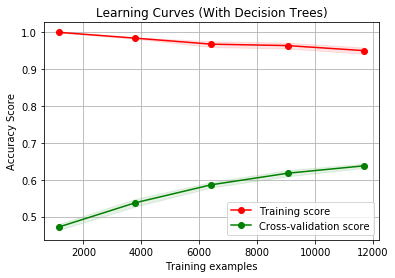

In [13]:
plotLearningCurve(DecisionTreeClassifier(max_depth=18), avocado_X_train, avocado_Y_train, 
                  "Learning Curves (With Decision Trees)", "Training examples", "Accuracy Score",
                  scoring="accuracy", n_jobs=4)

The learning curve shows low training error but a high cross-validation error that never converges. It seems that the best we can do is just under 64% accuracy. This is likely due to high variance (and low bias) that comes from noisy data and a complex model. Getting more data might help, but since the training score does not stay at its maximum as training examples increase, the model is likely not severely overfit. Just as a sanity check, we try max_depth = 10 and see that both training and CV scores suffer. 

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

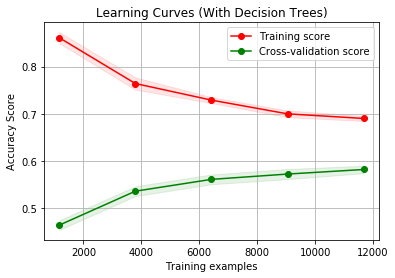

In [19]:
plotLearningCurve(DecisionTreeClassifier(max_depth=10), avocado_X_train, avocado_Y_train, 
                  "Learning Curves (With Decision Trees)", "Training examples", "Accuracy Score",
                  scoring="accuracy", n_jobs=4)

#### Neural Networks

We also use scikit-learn's implementation of neural networks, called MLPClassifier. By default, it uses a ReLU activation function and 'adam' solver, which refers to a stochastic gradient-based optimizer that works well on relatively large datasets. Just to be safe, we use 2 hidden layers of identical size, and choose several sizes of hidden neurons somewhere between the size of the input and output layers. Because of the higher-dimensional space of hyperparameters, we will use GridSearchCV to heuristically determine the optimal configuration. 

In [11]:
parameters_multiple = {'solver': ['adam'], 'max_iter': [200,500,1000], 'alpha' : 10.0 ** -np.arange(1, 7), 
                       'hidden_layer_sizes': [(25,25), (30,30), (35,35), (40,40)], 'verbose': [3], 'random_state': [1]}
    
clf_grid_multi = GridSearchCV(MLPClassifier(), parameters_multiple, scoring = "accuracy", n_jobs=8)

clf_grid_multi.fit(avocado_X_train, avocado_Y_train.values.ravel())

print("-----------------Original Features--------------------")
print("Best score: %0.4f" % clf_grid_multi.best_score_)
print("Using the following parameters:")
print(clf_grid_multi.best_params_)
print("------------------------------------------------------")

Iteration 1, loss = 1.48843562
Iteration 2, loss = 1.21831911
Iteration 3, loss = 1.08944077
Iteration 4, loss = 1.01992834
Iteration 5, loss = 0.97495906
Iteration 6, loss = 0.94245455
Iteration 7, loss = 0.91884639
Iteration 8, loss = 0.89971090
Iteration 9, loss = 0.88314341
Iteration 10, loss = 0.86934622
Iteration 11, loss = 0.85575451
Iteration 12, loss = 0.84302475
Iteration 13, loss = 0.83184229
Iteration 14, loss = 0.81929984
Iteration 15, loss = 0.80887314
Iteration 16, loss = 0.79860293
Iteration 17, loss = 0.79015457
Iteration 18, loss = 0.77962919
Iteration 19, loss = 0.77021201
Iteration 20, loss = 0.76278196
Iteration 21, loss = 0.75490813
Iteration 22, loss = 0.74659516
Iteration 23, loss = 0.73877830
Iteration 24, loss = 0.73052161
Iteration 25, loss = 0.72529334
Iteration 26, loss = 0.71770837
Iteration 27, loss = 0.71252903
Iteration 28, loss = 0.70637280
Iteration 29, loss = 0.70113793
Iteration 30, loss = 0.69268004
Iteration 31, loss = 0.68744322
Iteration 32, los

GridSearchCV on neural networks took the longest wall clock time by far, but it pays off in an improved accuracy score of 69.6%! Plugging in the tuned hyperparameter values, now we graph the neural network's performance against "time" in a validation curve, in this case maximum iterations, which determine epochs (and, in turn, how many times each data point will be used) under stochastic solvers like 'adam.' We adjust the hidden layer sizes to 38, calculated from averaging 72 features and 5 output classes.

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

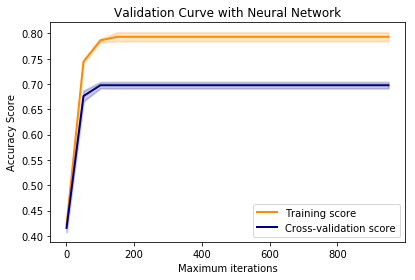

In [19]:
calculateValidationCurve(MLPClassifier(alpha=0.001, hidden_layer_sizes=(38,38), random_state=1, solver='adam', verbose=False), 
                         avocado_X_train, avocado_Y_train.values.ravel(),
                         "max_iter", range(1,1000,50),
                         "Validation Curve with Neural Networks", "Maximum iterations", "Accuracy Score", 
                         scoring="accuracy", n_jobs=8)

Performance for the cross-validation sets plateau at 100 max iterations, which suggests that the neuron weights are quickly adjusted, and more upper-limit computation time does not benefit the model accuracy. 

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

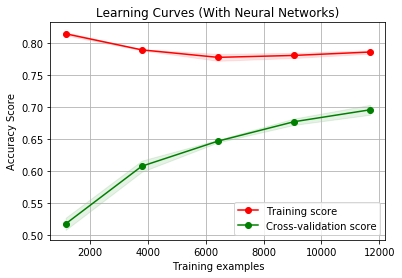

In [22]:
plotLearningCurve(MLPClassifier(alpha=0.001, hidden_layer_sizes=(38,38), random_state=1, solver='adam', max_iter=100, verbose=False),
                  avocado_X_train, avocado_Y_train.values.ravel(), 
                  "Learning Curves (With Neural Networks)", "Training examples", "Accuracy Score",
                  scoring="accuracy", n_jobs=4)

The upward CV accuracy in the learning curve graph for neural networks with tuned hyperparameters suggest that the model may benefit from more data, or perhaps more importantly, a simpler model with fewer features. The regularizatiton term tuned from GridSearchCV, alpha = 0.001, is higher than the sklearn default value, likely contributing to the neural network's strong generalizability. Even with the additional expressiveness of a neural network, the training accuracy hovers under 80%, indicating irreducible noise inherent to the data. Instead, the gap between the training and CV score might be closed by reducing the number of parameters using methods like principle component analysis (PCA) on the encoded data to avoid overfitting.

#### Boosting

We use scikit-learn's AdaBoostClassifier with decision stumps (aggressive pruning) and default values for all else. Uniquely, the cross validation accuracy for boosted classifiers should never truly plateau, so we will choose to graph the boosted estimator's performance up to 2000 estimators. 

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

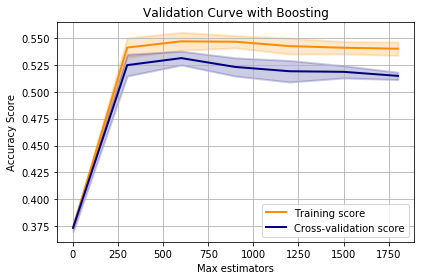

In [36]:
calculateValidationCurve(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)), 
                         avocado_X_train, avocado_Y_train.values.ravel(),
                         "n_estimators", range(1,2000,300),
                         "Validation Curve with Boosting", "Max estimators", "Accuracy Score", 
                         scoring="accuracy", n_jobs=4)

This is a surprising result. The validation curve shows CV accuracy increasing in line with training accuracy, but unexpectedly, both curves taper off after around 600 estimators. What is causing this? Plugging in n_estimators = 600 into the learning curves:

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

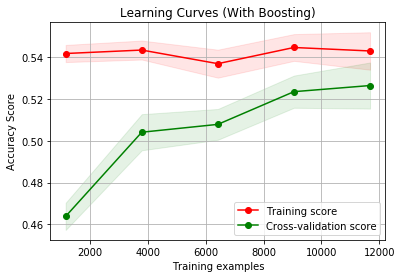

In [38]:
plotLearningCurve(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=600), 
                  avocado_X_train, avocado_Y_train.values.ravel(), 
                  "Learning Curves (With Boosting)", "Training examples", "Accuracy Score",
                  scoring="accuracy", n_jobs=4)

A similar result is seen in the learning curves. The training accuracy stalls at 54%. More data probably will not permit for us to achieve higher than around 55% accuracy. Unfortunately, this is the worst performing classifier yet, and as an ensemble model, it naturally runs much slower than a single decision tree, too. The main factors influencing this poor performance are the high noise and dimensionality in the data. The CV and the training accuracy scores converge to a value that is too low with increasing size of the training set. Because of this result, there is likely little significant benefit to running AdaBoost for more than 600 max estimators—while the algorithm is robust to overfitting, the high bias (systematic error) suggests the model cannot represent the underlying relationship as well as other algorithms. 

#### Support Vector Machines

We use scikit-learn's linear kernel implementation of SVM, called LinearSVC. Because it is implemented with liblinear, LinearSVC has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples. We leave other hyperparameters like penalty, loss, dual, multiclass, and max iterations at their default values.

[]

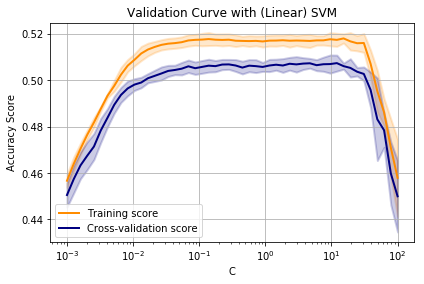

In [53]:
SvmValidationCurve = calculateValidationCurve(LinearSVC(), 
                                              avocado_X_train, avocado_Y_train.values.ravel(),
                                              "C", np.logspace(-3,2),
                                              "Validation Curve with (Linear) SVM", "C", "Accuracy Score", 
                                              scoring="accuracy", n_jobs=4)
ax = SvmValidationCurve.gca()
ax.semilogx()

Plotted on a logarithmic scale for C, the CV accuracy plateaus from 10<sup>-1</sup> to a tiny peak around C = 10<sup>1.3</sup>. We see that for values of C that are too small / too large, the model begins to underfit / overfit, respectively, and accuracy suffers as a result. 

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

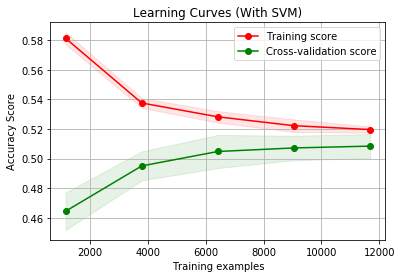

In [52]:
plotLearningCurve(LinearSVC(C=10**1.3),
                  avocado_X_train, avocado_Y_train.values.ravel(), 
                  "Learning Curves (With SVM)", "Training examples", "Accuracy Score",
                  scoring="accuracy", n_jobs=4)

Textbook validation and learning curves! Unfortunately, the peak accuracy of the linear kernel SVM algorithm is around 51% and won't break through anytime soon. Like our Boosting algorithm, the learning curves graph for SVM is clear: both the CV score and the training score converge to a value that is too low with increasing size of the training set. We will not benefit much from more training data because the dataset is too complex. 

#### *k*-Nearest Neighbors

Lastly, we implement scikit-learn's KNeighborsClassifier. We leave all hyperparameters like weights, algorithm, leaf size, p, and metric to their default values, but graph validation curves across values of *k* from 1 to 14. 

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

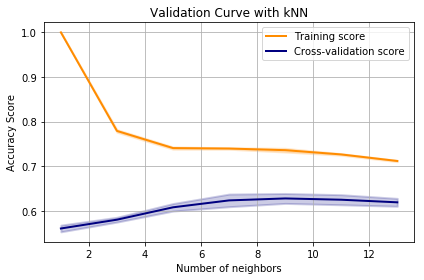

In [48]:
calculateValidationCurve(KNeighborsClassifier(), 
                         avocado_X_train, avocado_Y_train.values.ravel(),
                         "n_neighbors", range(1,14,2),
                         "Validation Curve with kNN", "Number of neighbors", "Accuracy Score", 
                         scoring="accuracy", n_jobs=4)

The algorithm accuracy quickly plateaus after k = 7, with a CV accuracy score around 63% at k = 9. Inverse to the other algorithms, as kNN increases in time & complexity with larger k, the model becomes less overfit to the training data and more generalizable. The training accuracy starts at 100% at k = 1 while the CV accuracy is naturally low, indicating high variance and low bias from being an oversimplistic model closely fit to the training data. 

Moving on, we plot performance as a function of training dataset size with *k* = 9:

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

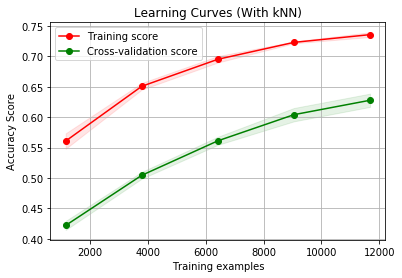

In [50]:
plotLearningCurve(KNeighborsClassifier(n_neighbors=9),
                  avocado_X_train, avocado_Y_train.values.ravel(), 
                  "Learning Curves (With kNN)", "Training examples", "Accuracy Score",
                  scoring="accuracy", n_jobs=4)

Astonishingly good performance. The learning curves for kNN maintain a 10% gap between training and CV, but the CV accuracy is nearing 64%. Again, the relatively high error in the training set suggests that the model is not overfitting, but that noise in the data makes correct classification difficult. 

#### Analysis of Training
In brief, we found the complexity and noise of data during training to be a confound that bounded cross-validation performance for all 5 models. All 5 algorithms generally resisted overfitting, and for Boosting and SVM, the underlying structure of the data proved to be so vexing that the learning curves show that they suffer from high bias and underfitting. 

In terms of wall clock runtimes, the validation and learning curves for the neural networks proved to be the most complex, followed by Boosting, then SVM and kNN. The curves for decision tree always ran in under 5 seconds.

### Testing

Finally, after conquering an arduous training regimen, we are ready to put each of our 5 algorithms to the test! Based on K-fold cross validation during hyperparameter tuning, we expect to find that the neural network will outperform the rest, although kNN may benefit more from the larger training superset.

In [15]:
# Fitting on entire training set
avocado_decisionTree = DecisionTreeClassifier(max_depth=18).fit(avocado_X_train, avocado_Y_train)
avocado_neuralNet = MLPClassifier(alpha=0.001, hidden_layer_sizes=(38,38), random_state=1, solver='adam', max_iter=100, verbose=False).fit(avocado_X_train, avocado_Y_train.values.ravel())
avocado_AdaBoosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=600).fit(avocado_X_train, avocado_Y_train.values.ravel())
avocado_SVM = LinearSVC(C=10**1.3).fit(avocado_X_train, avocado_Y_train.values.ravel())
avocado_kNN = KNeighborsClassifier(n_neighbors=9).fit(avocado_X_train, avocado_Y_train.values.ravel())

# Predicting on X_test
avocado_decisionTree_Y_pred = avocado_decisionTree.predict(avocado_X_test)
avocado_neuralNet_Y_pred = avocado_neuralNet.predict(avocado_X_test)
avocado_AdaBoosting_Y_pred = avocado_AdaBoosting.predict(avocado_X_test)
avocado_SVM_Y_pred = avocado_SVM.predict(avocado_X_test)
avocado_kNN_Y_pred = avocado_kNN.predict(avocado_X_test)

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.4  0.23 0.22 0.1  0.05]
 [0.11 0.52 0.06 0.29 0.02]
 [0.34 0.09 0.47 0.04 0.07]
 [0.04 0.18 0.01 0.75 0.01]
 [0.28 0.05 0.42 0.02 0.22]]
             precision    recall  f1-score   support

 Very Cheap       0.34      0.40      0.37       720
      Cheap       0.50      0.52      0.51       761
    Average       0.39      0.47      0.42       701
     Pricey       0.62      0.75      0.68       739
Very Pricey       0.59      0.22      0.32       729

avg / total       0.49      0.47      0.46      3650

Normalized confusion matrix
[[0.55 0.22 0.19 0.02 0.03]
 [0.12 0.55 0.03 0.3  0.  ]
 [0.18 0.01 0.64 0.01 0.16]
 [0.02 0.09 0.   0.89 0.  ]
 [0.02 0.   0.18 0.   0.8 ]]
             precision    recall  f1-score   support

 Very Cheap       0.62      0.55      0.58       720
      Cheap       0.64      0.55      0.59       761
    Average       0.61      0.64      0.62       701
     Pricey       0.73      0.89      0.80       739
Very Pricey       0.81

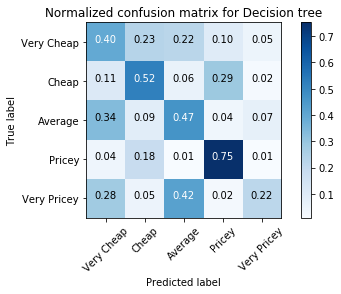

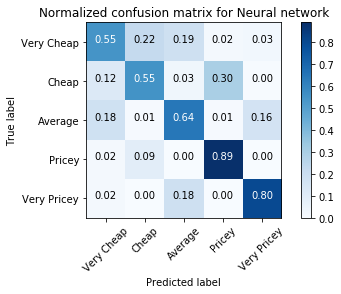

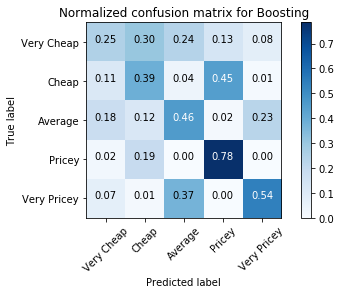

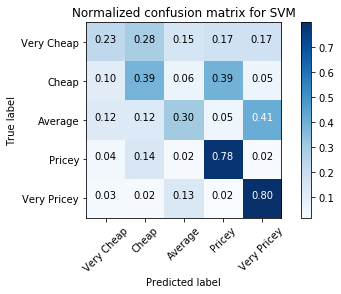

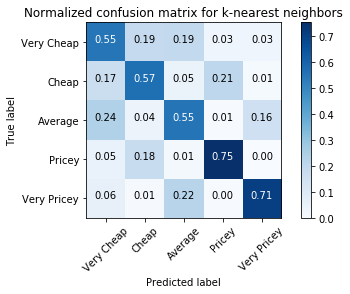

In [19]:
# Plot normalized confusion matrix and classification report on each algorithm
avocado_Y_pred = [(avocado_decisionTree_Y_pred, "Decision tree"), 
                  (avocado_neuralNet_Y_pred, "Neural network"), 
                  (avocado_AdaBoosting_Y_pred, "Boosting"), 
                  (avocado_SVM_Y_pred, "SVM"), 
                  (avocado_kNN_Y_pred, "k-nearest neighbors")]

for algorithm_Y_pred_tuple in avocado_Y_pred:    
    cnf_matrix = confusion_matrix(avocado_Y_test, algorithm_Y_pred_tuple[0])
    np.set_printoptions(precision=2)
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=avocado_price_range_labels, normalize=True,
                          title='Normalized confusion matrix for %s' % (algorithm_Y_pred_tuple[1]))
    
    print(classification_report(avocado_Y_test, algorithm_Y_pred_tuple[0], target_names=avocado_price_range_labels))

plt.show()

Our predictions were correct! As expected, the decision tree, neural network, and kNN benefited most from the full training set. Several specific observations to point out:
* Recall was lower than precision for Very Cheap and Cheap avocados across all models except the decision tree and kNN. The original price data was skewed right, which when discretized into price ranges likely contributed to very narrow margins between the labeled classes. Algorithms like SVM clearly had difficulty in sussing out them out, as seen in the confusion matrix.
* Conversely, the recall for Pricey avocados was very good for all algorithms, and Very Pricey for all except the decision tree.
* The decision tree was only able to find 22% of Very Pricey avocados and label them correctly, which is marginally better than guessing at random. 
* The neural network was able to identify 89% of Pricey avocados correctly! It was the clear winner with an average precision and recall around 68%. 
* The kNN was closely behind in 2nd place, with 63% precision and recall averaged across all classes. 

- - -

## Breast Cancer in Wisconsin
For our second classification problem, we'll explore a smaller, less balanced dataset on breast cancer diagnostics published in a paper from the University of Wisconsin. It was donated to the UCI Machine Learning repository in 1995 and is available on [Kaggle.com](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/).

In [16]:
cancer_data = pd.read_csv("./Datasets/breast-cancer-wisconsin-data.csv", sep=',', header='infer', index_col=0)
cancer_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. Ten real-valued features are computed for each cell nucleus: 

a) radius (mean of distances from center to points on the perimeter) <br>
b) texture (standard deviation of gray-scale values) <br>
c) perimeter <br>
d) area <br>
e) smoothness (local variation in radius lengths) <br>
f) compactness (perimeter^2 / area - 1.0) <br>
g) concavity (severity of concave portions of the contour) <br>
h) concave points (number of concave portions of the contour) <br>
i) symmetry <br>
j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features.

Similar to the avocado dataset, this dataset comes from real-world data and will likely be noisy. The difference is that gathering data from cancer patients and computing features from digital images of breast masses is a time-intensive process, so there are only 569 instances. Gathering more data or engineering more features is unlikely due to patient confidentiality and how long ago the data was collected. The engineered features (standard error & "worst" value of each feature) map the data to a nonlinear space, which will hopefully give our learning algorithms more to grab onto. Hopefully, they will be able to find interesting patterns in the data and contribute to better identification of breast cancers from cell characteristics. 

### Preprocessing

Feature engineering has already been done for us, and as stated at the beginning of the notebook, we will skip dimensionality reduction. There are no missing rows, and no need to encode or discretize data aside from the output label. Yay!

Splitting the data into training and testing sets before proceeding:

In [17]:
cancer_train, cancer_test = train_test_split(cancer_data, test_size=0.2)

#### Standardization

Just like in the Avocado Prices problem, we will standardize the dataset(s) to help our models fit better during training. Not previously mentioned, but it's important that we standardize training and testing data separately so as not to let the training data glean information like mean & variance from the testing set. 

In [18]:
scaler = StandardScaler()
unscaled_cols = cancer_train.columns[1:32]

cancer_train_scaled = cancer_train.copy()
cancer_test_scaled = cancer_test.copy()
cancer_train_scaled[unscaled_cols] = scaler.fit_transform(cancer_train_scaled[unscaled_cols])
cancer_test_scaled[unscaled_cols] = scaler.fit_transform(cancer_test_scaled[unscaled_cols])

Encode the output labels from 'B[enign]' and 'M[alignant]' to 0 and 1. 

In [19]:
# Use Pandas replace() to one-hot encode categorical output
cleanup_output = {"B": 0, "M": 1}
cancer_train_scaled.replace(cleanup_output, inplace=True)
cancer_test_scaled.replace(cleanup_output, inplace=True)

# Split data into features and outputs
cancer_Y_train = cancer_train_scaled.iloc[:, :1]
cancer_X_train = cancer_train_scaled.iloc[:, 1:]
cancer_Y_test = cancer_test_scaled.iloc[:, :1]
cancer_X_test = cancer_test_scaled.iloc[:, 1:]

### Training

Two important things to note:

* False negatives are more devastating than false positives. Assuming our models are hypothetically used to aid initial cancer diagnoses: follow-up examinations for breast cancer are relatively inexpensive, but missing a malignant tumor could have dire consequences for the unsuspecting patient who is sent home without follow-up. 
* This dataset is not balanced, but only slightly. The class distribution is 357 benign and 212 malignant—only a $63\%:37\%$ ratio, not bad for a binary classification problem.

Based on the above, *we will use recall as our classification scoring metric* to evaluate the algorithms. We will not oversample or undersample the data.

#### Decision Trees with Pre-Pruning
We use the default implementation for DecisionTreeClassifier, which uses Gini impurity to measure the quality of a split. Plotting the max depth of the decision trees against the accuracy score gives us the following graph:

<module 'matplotlib.pyplot' from '/Users/ericgu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

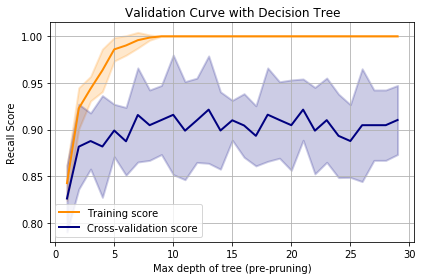

In [92]:
calculateValidationCurve(DecisionTreeClassifier(), cancer_X_train, cancer_Y_train,
                         "max_depth", range(1,30),
                         "Validation Curve with Decision Tree", "Max depth of tree (pre-pruning)", "Recall Score", 
                         scoring="recall", n_jobs=4)

It looks like the training score reaches maximum at around max depth = 9. As the decision trees grow larger, the CV recall score fails to improve, and hovers between 88–93%. It appears that our model has very low bias, and the gap between training and CV performance can be explained by varying training data. 

To avoid overfitting too much, let's choose max_depth = 7 to plot the learning curve:

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

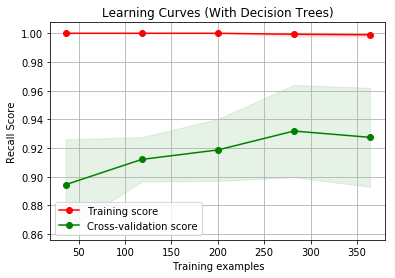

In [7]:
plotLearningCurve(DecisionTreeClassifier(max_depth=7), cancer_X_train, cancer_Y_train, 
                  "Learning Curves (With Decision Trees)", "Training examples", "Recall Score",
                  scoring="recall", n_jobs=4)

The learning curve shows low training error but a high cross-validation error that never converges. It seems that the best we can do is just under 93% recall. Getting more data would help, but since the training score does not quite stay at its maximum as training examples go to 350, the model is likely not severely overfit. 

#### Neural Networks

Once again, we use MLPClassifier with a ReLU activation function. But this time, we opt for the 'lbfgs' solver, which can converge faster and perform better on smaller datasets. We will use only 1 hidden layer, and choose several sizes of hidden neurons somewhere between the size of the input and output layers. Because of the higher-dimensional space of hyperparameters, we will use GridSearchCV to heuristically determine the optimal configuration. 

In [8]:
parameters_multiple = {'solver': ['lbfgs'], 'max_iter': [100,200,500], 'alpha' : 10.0 ** -np.arange(1, 7), 
                       'hidden_layer_sizes': [(10), (15), (18), (20)], 'verbose': [3], 'random_state': [1]}
    
clf_grid_multi = GridSearchCV(MLPClassifier(), parameters_multiple, scoring = "recall", n_jobs=8)

clf_grid_multi.fit(cancer_X_train, cancer_Y_train.values.ravel())

print("-----------------Original Features--------------------")
print("Best score: %0.4f" % clf_grid_multi.best_score_)
print("Using the following parameters:")
print(clf_grid_multi.best_params_)
print("------------------------------------------------------")

-----------------Original Features--------------------
Best score: 0.9697
Using the following parameters:
{'alpha': 0.01, 'hidden_layer_sizes': 18, 'max_iter': 100, 'random_state': 1, 'solver': 'lbfgs', 'verbose': 3}
------------------------------------------------------


Surprisingly, GridSearchCV on neural networks took mere seconds of wall clock time, but it pays off in an improved recall score of 96.97% on the (default 3-fold) cross-validation sets! This is astonishingly good performance.

How does it perform against time? Plugging in the tuned hyperparameter values, now we graph the neural network's performance against maximum iterations in a validation curve. 

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

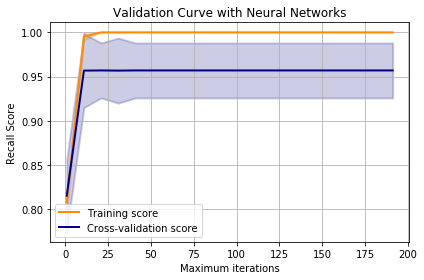

In [25]:
calculateValidationCurve(MLPClassifier(alpha=0.01, hidden_layer_sizes=(18), random_state=1, solver='lbfgs', verbose=False), 
                         cancer_X_train, cancer_Y_train.values.ravel(),
                         "max_iter", range(1,200,10),
                         "Validation Curve with Neural Networks", "Maximum iterations", "Recall Score", 
                         scoring="recall", n_jobs=8)

Performance for the CV immediately reaches maximum score after only 10 max iterations. This suggests that the neuron weights are adjusted extremely quickly, and more upper-limit computation time does not benefit the model recall. We should be concerned about overfitting, but the error in the CV sets is already under 5% and more data cannot be collected. The only alternative is to simplify the model, but GridSearchCV already determined 18 nodes to be superior in performance to 15 or 20 nodes. The validation curve on hidden layer size shows that there are indeed no gains to be had by reducing complexity. 

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

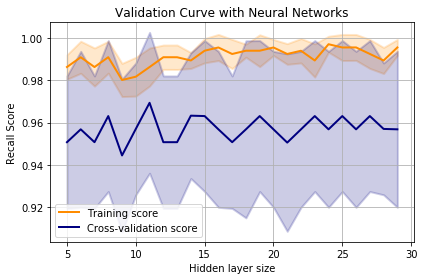

In [26]:
calculateValidationCurve(MLPClassifier(alpha=0.01, max_iter=10, random_state=1, solver='lbfgs', verbose=False), 
                         cancer_X_train, cancer_Y_train.values.ravel(),
                         "hidden_layer_sizes", range(5,30),
                         "Validation Curve with Neural Networks", "Hidden layer size", "Recall Score", 
                         scoring="recall", n_jobs=8)

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

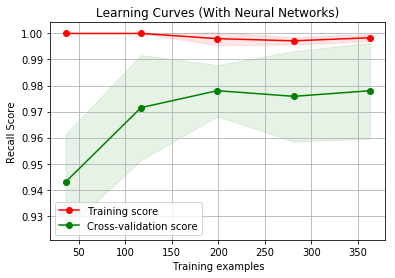

In [27]:
plotLearningCurve(MLPClassifier(alpha=0.01, hidden_layer_sizes=(18), random_state=1, solver='lbfgs', max_iter=10, verbose=False),
                  cancer_X_train, cancer_Y_train.values.ravel(), 
                  "Learning Curves (With Neural Networks)", "Training examples", "Recall Score",
                  scoring="recall", n_jobs=4)

The expressiveness of the neural network with only 18 hidden nodes and 10 max iterations attests to the algorithm's suitability to the problem and the relatively low noise in the dataset, even despite its small size. With a recall of nearly 98% with approximately 360 training examples, we can be confident that the neural network seems to be a strong candidate and might do even better with the full training set. 

#### Boosting

We use scikit-learn's AdaBoostClassifier with decision stumps and default values for all else. The cross validation recall for boosted classifiers should never truly plateau, so we will choose to graph the boosted estimator's performance up to 800 estimators. 

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

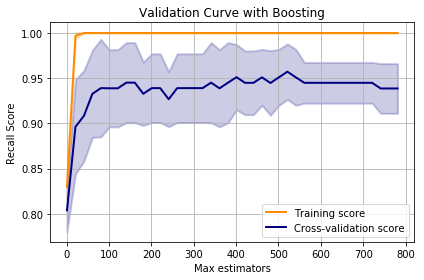

In [24]:
calculateValidationCurve(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)), 
                         cancer_X_train, cancer_Y_train.values.ravel(),
                         "n_estimators", range(1,800,20),
                         "Validation Curve with Boosting", "Max estimators", "Recall Score", 
                         scoring="recall", n_jobs=4)

Similar to the Avocado Prices problem, performance plateaus quickly for AdaBoost, this time after 80 max estimators. However, unlike the Avocado problem, the training score reaches 100%, and the CV score hovers around 95%. 

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

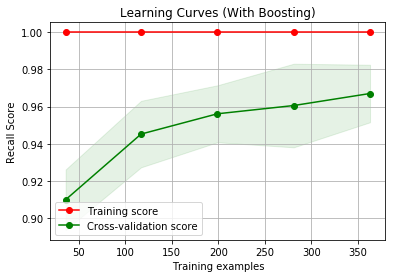

In [30]:
plotLearningCurve(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=80), 
                  cancer_X_train, cancer_Y_train.values.ravel(), 
                  "Learning Curves (With Boosting)", "Training examples", "Recall Score",
                  scoring="recall", n_jobs=4)

With clean, less noisy data, we find that Boosting improves beats the decision tree's performance with under 97% recall at 80 weak estimators. The gap between training and CV error would continue to close with more training data, but reducing the number of estimators would probably not help the model to generalize better. 

#### Support Vector Machines

We use LinearSVC with default values.

[]

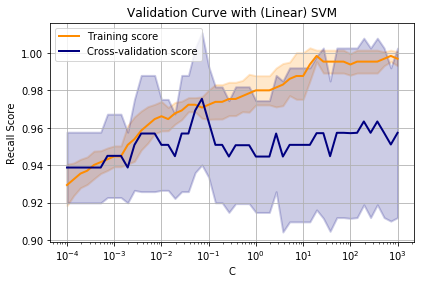

In [32]:
SvmValidationCurve = calculateValidationCurve(LinearSVC(), 
                                              cancer_X_train, cancer_Y_train.values.ravel(),
                                              "C", np.logspace(-4,3),
                                              "Validation Curve with (Linear) SVM", "C", "Recall Score", 
                                              scoring="recall", n_jobs=4)
ax = SvmValidationCurve.gca()
ax.semilogx()

This is a jagged graph. Plotted on a logarithmic scale for C, the CV accuracy peaks around C = 10<sup>-1.3</sup>. At its peak, the CV set has almost 98% recall, but also sees relatively enormous variance in recall performance across training sets that overlaps with the training score's mean line. We see from the training set that as C increases, the model bias should decrease but the CV performance stalls because of the increasingly large variance. 

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

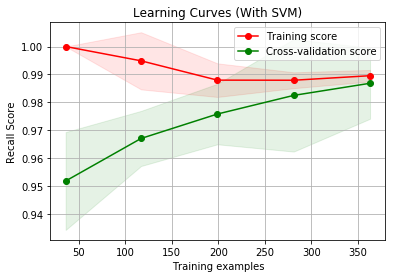

In [33]:
plotLearningCurve(LinearSVC(C=10**-1.3),
                  cancer_X_train, cancer_Y_train.values.ravel(), 
                  "Learning Curves (With SVM)", "Training examples", "Recall Score",
                  scoring="recall", n_jobs=4)

A beautiful learning curve! The peak score of the CV set is almost at 99%, and the training score almost converges with it. This is the best performing model yet, and reflects SVM's ability to find the maximum "margins" between classes with less noise and a simpler problem.

#### *k*-Nearest Neighbors

Lastly, we implement KNeighborsClassifier. We leave all hyperparameters like weights, algorithm, leaf size, p, and metric to their default values, but graph validation curves across values of *k* from 1 to 20. 

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

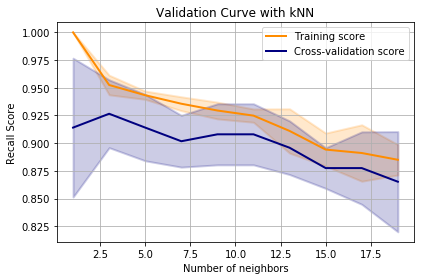

In [35]:
calculateValidationCurve(KNeighborsClassifier(), 
                         cancer_X_train, cancer_Y_train.values.ravel(),
                         "n_neighbors", range(1,20,2),
                         "Validation Curve with kNN", "Number of neighbors", "Recall Score", 
                         scoring="recall", n_jobs=4)

Interestingly, both the training and CV scores decrease as k increases. The CV recall never breaks 93%. This possibly suggests that as model complexity increases, the error from variance outpaces the decrease in bias. Since previous models have achieved extremely high recall, noise in the dataset is probably low, and suggests that the underlying structure of the problem is not as simple as finding the closest points in hyperspace. 

<module 'matplotlib.pyplot' from 'c:\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

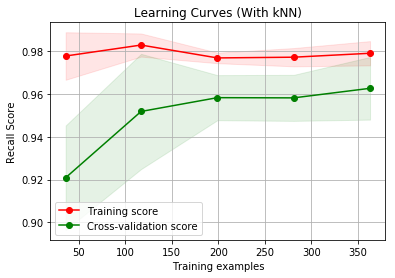

In [38]:
plotLearningCurve(KNeighborsClassifier(n_neighbors=3),
                  cancer_X_train, cancer_Y_train.values.ravel(), 
                  "Learning Curves (With kNN)", "Training examples", "Recall Score",
                  scoring="recall", n_jobs=4)

With more data, kNN CV recall score improves to 96%. k = 3 seems to minimizes both bias and variance. The gap between training and CV is pretty small, and it's doubtful if more training data will dramatically improve test performance. 

#### Training Analysis
A naive decision tree seems to perform the worst, followed by kNN. Based on the learning curves, it's hard to tell whether neural networks, boosting, or SVM will gain the most from fitting on the full training set. However, it's clear that this Breast Cancer dataset and particular scoring metric (recall) has led to a much closer race between the 5 algorithms. The simplicity of the problem tempts the reader to interpret the low training error and gap in CV error as overfitting, but the variance comes from the inherent bias-variance trade-off and the noise in the data.

### Testing

Normalized confusion matrix
[[0.92 0.08]
 [0.06 0.94]]
             precision    recall  f1-score   support

     Benign       0.95      0.92      0.94        65
  Malignant       0.90      0.94      0.92        49

avg / total       0.93      0.93      0.93       114

Normalized confusion matrix
[[1.   0.  ]
 [0.08 0.92]]
             precision    recall  f1-score   support

     Benign       0.94      1.00      0.97        65
  Malignant       1.00      0.92      0.96        49

avg / total       0.97      0.96      0.96       114

Normalized confusion matrix
[[1.   0.  ]
 [0.06 0.94]]
             precision    recall  f1-score   support

     Benign       0.96      1.00      0.98        65
  Malignant       1.00      0.94      0.97        49

avg / total       0.97      0.97      0.97       114

Normalized confusion matrix
[[1.   0.  ]
 [0.08 0.92]]
             precision    recall  f1-score   support

     Benign       0.94      1.00      0.97        65
  Malignant       1.00      

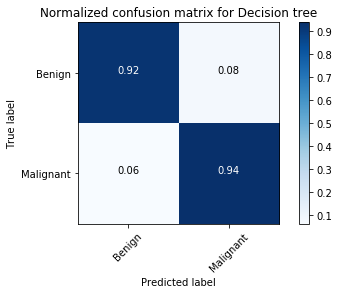

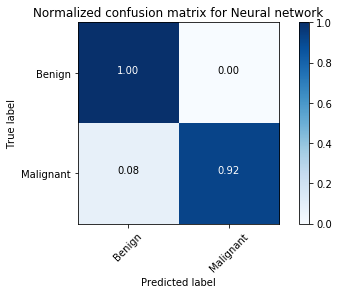

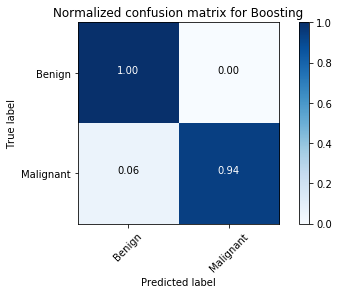

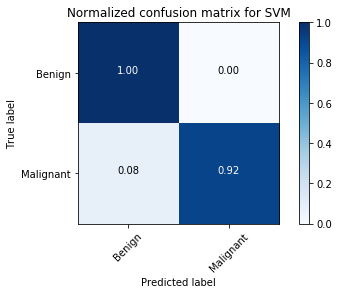

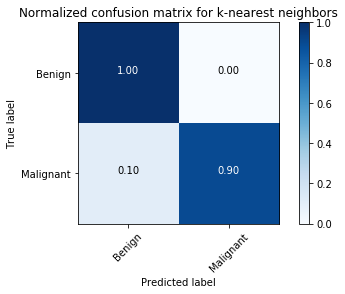

In [44]:
# Fitting on entire training set
cancer_decisionTree = DecisionTreeClassifier(max_depth=7).fit(cancer_X_train, cancer_Y_train)
cancer_neuralNet = MLPClassifier(alpha=0.01, hidden_layer_sizes=(18), random_state=1, solver='lbfgs', max_iter=10, verbose=False).fit(cancer_X_train, cancer_Y_train.values.ravel())
cancer_AdaBoosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=80).fit(cancer_X_train, cancer_Y_train.values.ravel())
cancer_SVM = LinearSVC(C=10**-1.3).fit(cancer_X_train, cancer_Y_train.values.ravel())
cancer_kNN = KNeighborsClassifier(n_neighbors=3).fit(cancer_X_train, cancer_Y_train.values.ravel())

# Predicting on X_test
cancer_decisionTree_Y_pred = cancer_decisionTree.predict(cancer_X_test)
cancer_neuralNet_Y_pred = cancer_neuralNet.predict(cancer_X_test)
cancer_AdaBoosting_Y_pred = cancer_AdaBoosting.predict(cancer_X_test)
cancer_SVM_Y_pred = cancer_SVM.predict(cancer_X_test)
cancer_kNN_Y_pred = cancer_kNN.predict(cancer_X_test)

# Plot normalized confusion matrix and classification report on each algorithm
cancer_Y_pred = [(cancer_decisionTree_Y_pred, "Decision tree"), 
                  (cancer_neuralNet_Y_pred, "Neural network"), 
                  (cancer_AdaBoosting_Y_pred, "Boosting"), 
                  (cancer_SVM_Y_pred, "SVM"), 
                  (cancer_kNN_Y_pred, "k-nearest neighbors")]

for algorithm_Y_pred_tuple in cancer_Y_pred:
    cnf_matrix = confusion_matrix(cancer_Y_test, algorithm_Y_pred_tuple[0])
    np.set_printoptions(precision=2)
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Benign', 'Malignant'], normalize=True,
                          title='Normalized confusion matrix for %s' % (algorithm_Y_pred_tuple[1]))
    
    print(classification_report(cancer_Y_test, algorithm_Y_pred_tuple[0], target_names=['Benign', 'Malignant']))

plt.show()

The decision tree and AdaBoost models tied with 94% recall on malignant tumors, with the neural network and SVM tied closely  for 2nd at 92% recall. All algorithms except decision tree identified malignant with 100% precision, which means that in all instances in the testing set, if any of the 4 algorithms predicted a 'Malignant' diagnosis, the breast mass was truly malignant. Thus, Boosting is our winner. 

Unfortunately, we were unable to reach 100% recall for malignant masses on any of the algorithms, which reflects the fundamental difficulty in the real-world problem of distinguishing between malignant and benign growths from digital images in edge cases. It's very likely that some growths that look benign are not as they appear, and it's what makes identifying cancer with certainty so difficult. 

Overall, the lower noise, size, and complexity of the dataset (fewer features and classifications) and healthy use of cross-validation and hyperparameter tuning during training made for wider "margins" in the boundaries between the data. Though less noisy, those boundaries were probably not linear, which is why we saw that kNN performance lagged behind more expressive, curvy models like Boosting. 